# Part I: Code Your Neural Network!


##1.0 Setup

In [ ]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1


def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

    fig, ax = plt.subplots(figsize=(8, 6))
    iters = np.arange(1,len(train_costs)+1)
    ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
    ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
    ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
    ax.set_ylabel("Cost")
    ax.legend(loc="upper right", frameon=False)
    ax.set_title(title)
    plt.show()

def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

    # Create a grid of points spanning the parameter space:
    x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                           np.arange(range[0], range[1]+step, step)
    )

    # Stack it so that it is shaped like X_train: (m,2)
    X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

    # Feedforward on all grid points and get binary predictions:
    output = feedforward(X_grid, weights, biases)[-1] # getting only output node
    Ypred_grid = predict(output, boundary)

    return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None,
                 xname=XNAME, xlabel=XLABEL,
                 yname=YNAME, ylabel=YLABEL,
                 range=RANGE, step=STEP, title="Scatter plot"):

    fig, ax = plt.subplots()

    # Decision surface
    if ds:
        (xx, yy, Z) = ds # unpack contour data
        cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

    # Scatter signal and background:
    ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
    ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

    # Axes, legend and plot:
    ax.set_xlim(range); ax.set_xlabel(xlabel)
    ax.set_ylim(range); ax.set_ylabel(ylabel)

    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
    ax.set_title(title)
    plt.show()

## 1.1 Get the Data

In [ ]:
### 1.1.1 File Download

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/intro_ml/

/content/gdrive/MyDrive/intro_ml


In [ ]:
data_path = "/content/gdrive/MyDrive/intro_ml/"
data_file_train = "ml_tutorial_5_data_train.csv"
data_file_test = "ml_tutorial_5_data_test.csv"

In [ ]:
dftrain = pd.read_csv(data_file_train)
dftrain.head()

,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0


In [ ]:
dftrain.shape

(320, 3)

In [ ]:
dftest = pd.read_csv(data_file_test)
dftest.head()

,x1,x2,class
0,3.967433,5.580323,1
1,-5.324361,-4.574185,1
2,5.635016,3.301594,1
3,2.369043,-2.431812,0
4,3.607040,-3.598197,0


In [ ]:
dftest.shape

(80, 3)

### 1.1.2 Split Signal vs Background

In [ ]:
sig = dftrain.loc[(dftrain['class']== 1)]
bkg = dftrain.loc[(dftrain['class']== 0)]
print("sig", sig.shape)
print("bkg", bkg.shape)

sig (149, 3)
bkg (171, 3)


### 1.1.3 Dataframe to NumPy

In [ ]:
inputs = ['x1', 'x2']
X_train = dftrain[inputs].to_numpy()
y_train = dftrain[['class']].to_numpy()

X_test = dftest[inputs].to_numpy()
y_test = dftest[['class']].to_numpy()

print(X_train.shape)
print(y_train.shape)

(320, 2)
(320, 1)


## 1.2 Functions

### 1.2.1 Weighted Sum

In [ ]:
def z(a_prev, Weights , biases):
  """
    Calculates the weighted sum for a layer of the neural network (Z = W.T * A + b).

    Args:
        a_prev (np.array): Activations from the previous layer.
                           Shape: (m, n_prev, 1), where m is batch size, n_prev is nodes in previous layer.
        Weights (np.array): Weight matrix for the current layer.
                            Shape: (n_prev, n_curr), where n_curr is nodes in current layer.
        biases (np.array): Bias vector for the current layer.
                           Shape: (n_curr, 1).

    Returns:
        np.array: The linear combination (weighted sum) for the current layer.
                  Shape: (m, n_curr, 1).
    """
  z = np.matmul(Weights.T, a_prev) + biases

  return z

### 1.2.2 Activation Functions and Derivatives

In [ ]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_prime(z):
    return 1 - tanh(z)**2

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1 - sigmoid(z))

### 1.2.3: Cross-entropy cost function

In [ ]:
def cross_entropy_cost(y_pred, y_true):

  """
    Computes the binary cross-entropy cost.

    This function measures how far the predicted probabilities are from the actual 0/1 labels.

    Args:
        y_pred (np.array): Predicted probabilities. Shape: (m, 1, 1).
        y_true (np.array): True labels (0 or 1). Shape: (m, 1, 1).

    Returns:
        float: The average cross-entropy cost over all samples.
    """

  # Your code here
  m = y_true.shape[0]
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # This prevents taking log(0).

  return (-1/m) * np.sum(y_true* np.log(y_pred) + (1-y_true)* np.log(1-y_pred))

### 1.2.4 Derivative of the Loss

In [ ]:
def L_prime(y_pred, y_true):

  """
  Computes the derivative of the binary cross-entropy loss.

  Args:
    y_pred: The predicted values.
    y_true: The true labels.

  Returns:
    The derivative of the loss.
  """
  L_p = ((1 - y_true) / (1 - y_pred)) - (y_true / y_pred)
  return L_p


## 1.3 Feedforward Propagation

### 1.3.1 Implementing the Feedforward Function

We will start with the following network for now:

The network has two hidden layers

The nodes of the hidden layers use the hyperbolic tangent as activation function

The output layer uses the sigmoid function

In [ ]:
def feedforward(input_X, weights, biases):

    """
    Performs the feedforward pass for a 2-hidden-layer neural network.

    Args:
        input_X (np.array): The input data. Shape: (m, n_features), where n_features is 2.
        weights (list): A list of the network's weight matrices [W1, W2, W3].
        biases (list): A list of the network's bias vectors [b1, b2, b3].

    Returns:
        list: A list containing all activations and weighted sums from each layer
              [a0, z1, a1, z2, a2, z3, a3].
    """

    W1, W2, W3 = weights
    b1, b2, b3 = biases

    m  = len(input_X)
    a0 = input_X.reshape((m, -1, 1))

    # First layer
    z1 = z(a0, W1, b1)
    a1 = tanh(z1)

    # Second layer
    z2 = z(a1, W2, b2)
    a2 = tanh(z2)

    # Third layer
    z3 = z(a2, W3, b3)
    a3 = sigmoid(z3)

    nodes = [a0, z1, a1, z2, a2, z3, a3]
    return nodes

### 1.3.2 Predict


The predict function is already provided in the setup. Your task is to think about how it works:

What is the output_node in our 2-hidden-layer neural network?
Ans: Node a3

What kind of values does predict return?
Ans: 1 or 0 based on specific threshold, The function takes the continuous probability values from the output_node and compares them to a boundary_value.


After running feedforward, how would you call predict to get predictions?
Ans: pass the last element from the list returned by feedforward and a desired boundary value.



In [ ]:
def predict(output_node, boundary_value):
    output_node = output_node.reshape(-1, 1, 1)
    predictions = (output_node > boundary_value).astype(int)
    return predictions

### 1.4 Neural Network Training

In [ ]:
def print_every(iter_idx):
    if iter_idx <= 100:
        return iter_idx % 10 == 0
    elif iter_idx <= 1000:
        return iter_idx % 100 == 0
    else:
        return iter_idx % 1000 == 0

In [ ]:
# Hyperparameters
alpha  = 0.1
n_iter = 10000

# Initialization
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 6 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer


# WEIGHT MATRICES + BIASES
W1 = np.random.random(( n , q ))
W2 = np.random.random(( q , r ))
W3 = np.random.random(( r , 1 ))
b1 = np.random.random(( q , 1 ))
b2 = np.random.random(( r , 1 ))
b3 = np.random.random(( 1 , 1 ))

# OUTPUT LAYER
# Reshape target arrays to have a shape of (m, 1, 1) to match the network's output shape.
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []
debug = False

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for iter_idx in range(1, n_iter + 1):

    # FORWARD PROPAGATION
    # Feedforward on test data:
    nodes_test = feedforward(X_test, [W1, W2, W3], [b1, b2, b3])
    ypred_test = nodes_test[-1]

    # Feedforward on train data:
    a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, [W1, W2, W3], [b1, b2, b3])
    ypred_train = a3

    # Cost computation and storage
    cost_train = cross_entropy_cost(ypred_train, y_train)
    cost_test  = cross_entropy_cost(ypred_test,  y_test)
    costs_train.append(cost_train)
    costs_test.append(cost_test)

    # BACKWARD PROPAGATION
    # Errors delta:
    delta_3 = sigmoid_prime(z3) * L_prime(ypred_train, y_train)
    delta_2 = tanh_prime(z2) * (W3 @ delta_3)
    delta_1 = tanh_prime(z1) * (W2 @ delta_2)

    # Partial derivatives
    dCostdW3 = np.mean(a2 @ delta_3, axis=0)
    dCostdW2 = np.mean(a1 @ delta_2.transpose(0,2,1), axis=0)
    dCostdW1 = np.mean(a0 @ delta_1.transpose(0,2,1), axis=0)

    dCostdb3 = np.mean(delta_3, axis=0)
    dCostdb2 = np.mean(delta_2, axis=0)
    dCostdb1 = np.mean(delta_1, axis=0)

    # Print selected iterations
    if print_every(iter_idx):
        print(
            f"Iteration {iter_idx:>4}\t"
            f"Train cost: {cost_train:.5f}\t"
            f"Test cost: {cost_test:.5f}\t"
            f"Diff: {cost_test - cost_train:.2e}"
        )
    if debug and iter_idx < 3:
        print(
            f"Nodes: a0={a0.shape}, a1={a1.shape}, a2={a2.shape}, a3={a3.shape} | "
            f"Weights: W1={W1.shape}, W2={W2.shape}, W3={W3.shape} | "
            f"Gradients: dW1={dCostdW1.shape}, dW2={dCostdW2.shape}, dW3={dCostdW3.shape}"
        )

    # Update of weights and biases
    W3 = W3 - alpha * dCostdW3
    W2 = W2 - alpha * dCostdW2
    W1 = W1 - alpha * dCostdW1
    b3 = b3 - alpha * dCostdb3
    b2 = b2 - alpha * dCostdb2
    b1 = b1 - alpha * dCostdb1

print(f'\nEnd of gradient descent after {iter_idx} iterations')

Starting the training

Iteration   10	Train cost: 0.93016	Test cost: 0.87092	Diff: -5.92e-02
Iteration   20	Train cost: 0.79644	Test cost: 0.75642	Diff: -4.00e-02
Iteration   30	Train cost: 0.73113	Test cost: 0.70576	Diff: -2.54e-02
Iteration   40	Train cost: 0.69937	Test cost: 0.68545	Diff: -1.39e-02
Iteration   50	Train cost: 0.68303	Test cost: 0.67781	Diff: -5.22e-03
Iteration   60	Train cost: 0.67354	Test cost: 0.67481	Diff: 1.26e-03
Iteration   70	Train cost: 0.66704	Test cost: 0.67311	Diff: 6.07e-03
Iteration   80	Train cost: 0.66180	Test cost: 0.67144	Diff: 9.64e-03
Iteration   90	Train cost: 0.65703	Test cost: 0.66935	Diff: 1.23e-02
Iteration  100	Train cost: 0.65234	Test cost: 0.66671	Diff: 1.44e-02
Iteration  200	Train cost: 0.58996	Test cost: 0.61334	Diff: 2.34e-02
Iteration  300	Train cost: 0.48576	Test cost: 0.50879	Diff: 2.30e-02
Iteration  400	Train cost: 0.29824	Test cost: 0.29095	Diff: -7.29e-03
Iteration  500	Train cost: 0.19444	Test cost: 0.17786	Diff: -1.66e-02
Iter

## 1.5 Plots

### 1.5.1 Cost evolution


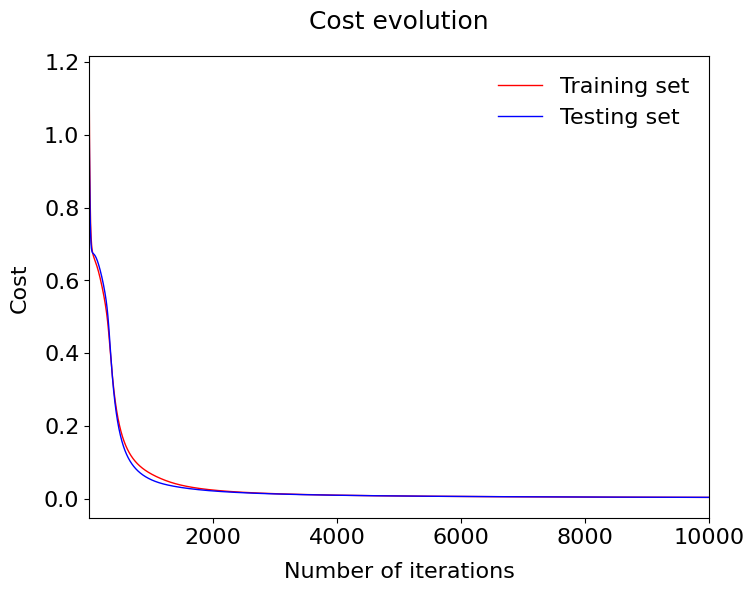

In [ ]:
plot_cost_vs_iter(costs_train, costs_test)


### 1.5.2 Scatter Plot

In [ ]:
ds= get_decision_surface([W1, W2, W3], [b1, b2, b3])

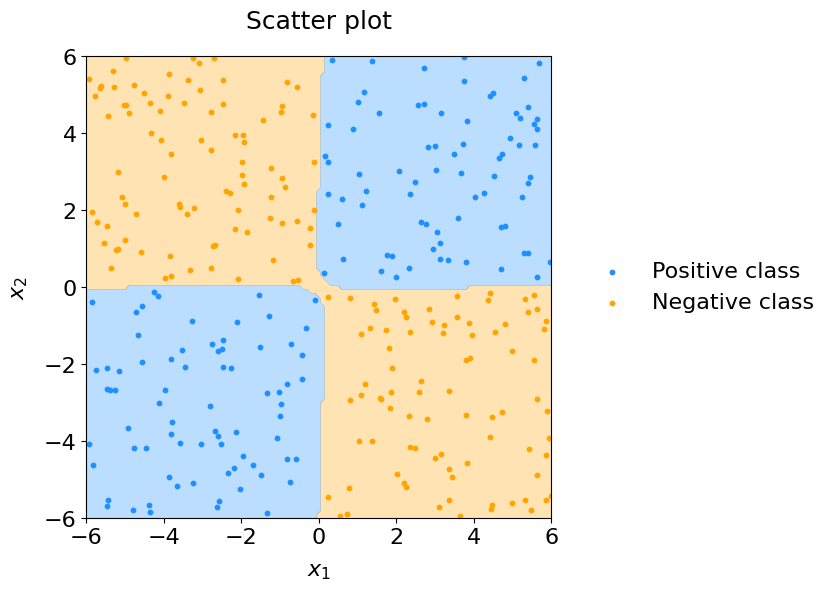

In [ ]:
plot_scatter(sig, bkg, ds= ds)